In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Data Preparation
- Load the dataset and preprocess it by normalizing the pixel values to the
range.
- Divide the dataset into training and testing sets (e.g., 80% training, 20%
testing).

In [ ]:
# Data Preparation
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize the data and flatten it
x_train = x_train.reshape((x_train.shape[0], -1)).astype('float32') / 255.0
x_test = x_test.reshape((x_test.shape[0], -1)).astype('float32') / 255.0

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


# RBM Implementation
- Define an RBM using a deep learning library (e.g., PyTorch, TensorFlow, or
Scikit-learn).
- Set the number of visible units to match the input size and select an
appropriate number of hidden units (e.g., 128 or 256).

In [ ]:
rbm = BernoulliRBM(n_components=256, learning_rate=0.01, batch_size=10, n_iter=10, verbose=False, random_state=42)
rbm.fit(x_train)

BernoulliRBM(learning_rate=0.01, random_state=42, verbose=False)

# Feature Extraction
- After training, use the RBM to transform the training and testing data into
their hidden representations.
- Save the hidden representations as feature vectors.

In [ ]:
X_train_rbm = rbm.transform(x_train)
X_test_rbm = rbm.transform(x_test)

# Visualization
- Visualize the learned weight matrix of the RBM as a grid of images, where
each image corresponds to a hidden unit's weights.

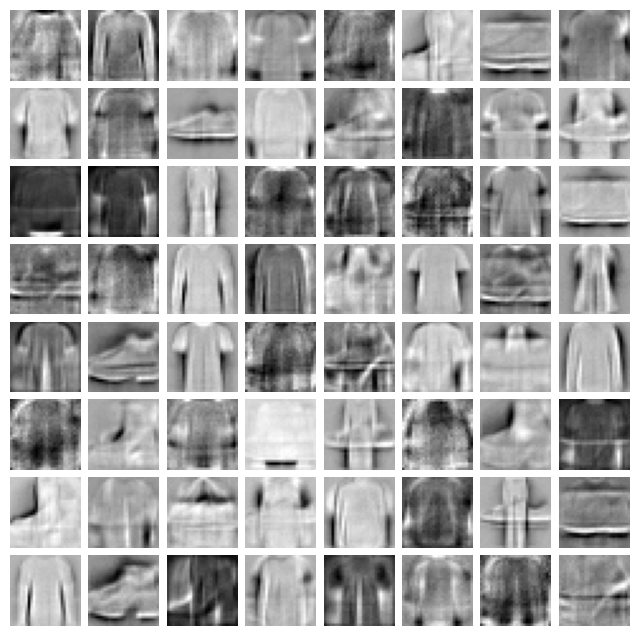

In [ ]:
# Get the weight matrix (components_) from the trained RBM
components = rbm.components_

fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(components[i].reshape(28, 28), cmap=plt.cm.gray)
    ax.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


# Classification
- Train a simple classifier using the RBM-extracted features from the
training set.
- Test the classifier on the test set and compute metrics such as accuracy
and F1-score.

In [ ]:
# Train an SVM classifier on the RBM-extracted features
svm = SVC(kernel='rbf', gamma=0.05)
svm.fit(X_train_rbm, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test_rbm)

In [ ]:
# Print the classification report
print(classification_report(y_test, y_pred))
print("F1 Score",f1_score(y_test, y_pred, average='macro'))
print("Accuracy Score",accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.85      0.83      1000
           1       0.99      0.95      0.97      1000
           2       0.74      0.80      0.77      1000
           3       0.87      0.89      0.88      1000
           4       0.76      0.77      0.76      1000
           5       0.97      0.93      0.95      1000
           6       0.69      0.59      0.64      1000
           7       0.91      0.95      0.93      1000
           8       0.96      0.97      0.97      1000
           9       0.94      0.94      0.94      1000

    accuracy                           0.87     10000
   macro avg       0.86      0.87      0.86     10000
weighted avg       0.86      0.87      0.86     10000

F1 Score 0.8643099850735305
Accuracy Score 0.8653


# Analysis

In [ ]:
# Train an SVM classifier on the Non-RBM-extracted features
svm2 = SVC(kernel='rbf', gamma=0.05)
svm2.fit(x_train, y_train)

# Make predictions on the test set
y_pred_n = svm2.predict(x_test)

# Print the classification report
print(classification_report(y_test, y_pred_n))
print("F1 Score",f1_score(y_test, y_pred_n, average='macro'))
print("Accuracy Score",accuracy_score(y_test, y_pred_n))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1000
           1       1.00      0.97      0.98      1000
           2       0.81      0.82      0.81      1000
           3       0.89      0.90      0.89      1000
           4       0.83      0.82      0.83      1000
           5       0.97      0.98      0.97      1000
           6       0.73      0.70      0.71      1000
           7       0.95      0.97      0.96      1000
           8       0.94      0.98      0.96      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

F1 Score 0.8931291176859618
Accuracy Score 0.8935


- RBM helps extract more meaningful features by transforming raw, high-dimensional pixel data into compact, high-level representations that are more suitable for classification.
- These features capture important patterns and structures in the data that raw pixels may miss, leading to improved performance in machine learning tasks.
- The ability to learn sparse, non-linear representations also makes RBMs particularly useful for tasks like image recognition, where the relationships between pixels and objects are complex.